In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.weightstats import DescrStatsW

In [2]:
data_dir = '/Volumes/BOY/DANewData/'

In [3]:
all_data = data_dir + 'DATA_fc=60.pkl'

In [4]:
pd_all_data = pd.read_pickle(all_data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexes/base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [5]:
state_data = pd_all_data[0.7000000000000002][-200]['State']

In [6]:
state_data = np.vstack(state_data.values)

In [7]:
obs_data = np.vstack(pd_all_data[0.7000000000000002][-200][1].values)

In [8]:
obs_data.shape

(1000, 5)

In [9]:
obs_data_true = np.vstack(pd_all_data[0.7000000000000002][-200][0].values)

In [10]:
tinit=0
tdelta=0.05


In [11]:
import numpy as np
import config
import Model
import ObservationOperator

CFP = config.CFP

TM = getattr(Model,CFP['TrueModel']['model_equation'])
# Forcast model
TF = getattr(Model,CFP['RunModel']['model_equation'])
Hm = getattr(ObservationOperator,CFP['DataAssimilation']['observation_operator'])

linear = CFP['DataAssimilation'].getboolean('linear')
random_seed = CFP['DataAssimilation'].getfloat('random_seed')

number_observation = 200
dimension_state = CFP['RunModel'].getint('dimension')
dimension_observation = CFP['ObservationGeneration'].getint('dimension_observation')
number_ensemble = 100

#data = np.load(CFP['DataAssimilation']['data_source'])
#obs  = np.load(CFP['DataAssimilation']['observation_source'])

truestate = state_data[:number_observation,:]
tinit = 0.0
tdelta = 0.05
tobs = np.arange(number_observation) * tdelta + tinit

trueobs = obs_data_true[:number_observation,:]
yobs = obs_data[:number_observation,:]

sigma_init = CFP['DataAssimilation'].getfloat('sigma_init')

inflation = CFP['DataAssimilation'].getfloat('inflation')

value_bound_upper = config.GetArray('RunModel','value_bound_upper')
value_bound_lower = config.GetArray('RunModel','value_bound_lower')

def resampleMultinomial(W):

    M = len(W)
    Q = np.cumsum(W)
    Q[:-1]=1

    indx = np.zeros(M,dtype=int)
    i=0
    while i<M:
        sampl = np.random.uniform(0,1)
        j=0
        while Q[j]<sampl:
            j=j+1
        indx[i]=j
        i=i+1
    return indx
        
nobs = number_observation
dobs = dimension_observation
ndim = dimension_state
nens = number_ensemble

resampcount = 0

resamp_thresh = 0.5
wiggle = 0.1

## Containers
xfm = np.zeros([nobs, ndim])
xam = np.zeros([nobs, ndim])
xfcov = np.zeros([nobs, ndim, ndim])
xacov = np.zeros([nobs, ndim, ndim])

yfm = np.zeros([nobs, dobs])
yfcov = np.zeros([nobs, dobs, dobs])

xinit = truestate[0,:]
sigmainit = sigma_init

## set the initial mean and covariance:

sigma = xinit * np.clip(sigmainit * np.random.randn(*xinit.shape),-0.2,0.2)

xfm[0,:] = xam[0,:] = xinit + sigma
xfcov[0,:,:] = xacov[0,:,:] = np.identity(ndim) * (sigma ** 2)

phist = np.zeros([nobs,nens,ndim])
whist = np.zeros([nobs,nens])

## Generate initial ensemble
xens = np.random.multivariate_normal(xam[0,:], xacov[0,:,:], nens)
xweights = np.ones(nens)/nens

xens = np.clip(xens,value_bound_lower,value_bound_upper)

phist[0,:,:] = xens
whist[0,:] = xweights

In [12]:
xens.shape

(100, 2)

In [13]:
## Iterate for each observation
for ii in np.arange(1,nobs):

    print(ii)
    ## How to inflate???
    Robsmat = np.diag(trueobs[1,:]**2 * 0.2)
    Robsmat_inv = np.linalg.pinv(Robsmat)

    ## Forecast
    for jj in np.arange(nens):
        xens[jj,:] = TF(xens[jj,:], tobs[ii-1], tobs[ii])

    ## Forecast mean and cov
    w_stats = DescrStatsW(xens,weights=xweights)
    xfm[ii,:] = w_stats.mean
    xfcov[ii,:,:] = w_stats.cov

    ## Observations generated from forecast
    ## Estimating the covariances with sample covariance
    yens = Hm(xens)
    w_stats = DescrStatsW(yens,weights=xweights)
    yfm[ii,:] = w_stats.mean
    yfcov[ii,:,:] = w_stats.cov

    innov = yens - yobs[ii,:]

    Wexp = np.zeros(nens)
    for _ii in range(nens):
        Wexp[_ii] = -0.5*innov[_ii,:] @ Robsmat_inv @ innov[_ii,:].T
    
    #Wexp =  -0.5*innov @ Robsmat_inv @ innov.T
    #Wexp = np.diag(Wexp)
    Wmax = np.max(Wexp)
    Wexp = Wexp - Wmax
    print(Wmax)
    W = xweights * np.exp(Wexp)
    W = W/np.sum(W)

    ##test for resampling
    if 1/np.sum(W ** 2)/nens < resamp_thresh:
        resampcount += 1
        print('Resampling the %dth time'%resampcount)
        sampIndex = resampleMultinomial(W)
        xens = xens[sampIndex,:] + wiggle*np.random.normal(0,1,size=(nens,ndim))
        W = np.ones(nens)/nens;

    xweights = W

    phist[ii,:,:] = xens
    whist[ii,:] = xweights
    
    ## Analysis mean and cov
    w_stats = DescrStatsW(xens,weights=xweights)
    xam[ii,:] = w_stats.mean
    xacov[ii,:,:] = w_stats.cov

## Calculate statistics
# Absolute errors
xferr = np.abs(xfm - truestate)
xaerr = np.abs(xam - truestate)

xferr10 = xferr[:,0:10]
xferr30 = xferr[:,10:]
xaerr10 = xaerr[:,0:10]
xaerr30 = xaerr[:,10:]

xferr10avgx = np.mean(xferr10,axis=1)
xaerr10avgx = np.mean(xaerr10,axis=1)

xferr30avgx = np.mean(xferr30,axis=1)
xaerr30avgx = np.mean(xaerr30,axis=1)

xferravgx = np.mean(xferr,axis=1)
xaerravgx = np.mean(xaerr,axis=1)

avgstp = 30
xferravgt = np.mean(xferr[avgstp:,:],axis=0)
xferravgxt = np.mean(xferravgt)

xaerravgt = np.mean(xaerr[avgstp:,:],axis=0)
xaerravgxt = np.mean(xaerravgt)

xferr10avgxt = np.mean(xferr10avgx)
xaerr10avgxt = np.mean(xaerr10avgx)

xferr30avgxt = np.mean(xferr30avgx)
xaerr30avgxt = np.mean(xaerr30avgx)

'''
np.savez(data_dir,
            ## Paramters
            # Notebook usage flags
            DESC=DESC,
            RSEED=RSEED,
            HTYPE=HTYPE,
            HERROR=HERROR,
            LINEAR=LINEAR,
            FORECAST_ERROR=FORECAST_ERROR,
            INFLATION=INFLATION,
            # Model parameters
            ndim=ndim,
            pars=pars,
            # Observation paramters
            nobs=nobs,
            deltaobs=deltaobs,
            dobs=dobs,
            Hmat=Hmat,
            sigmaobs=sigmaobs,

            ## DA paramters
            infl_lin=infl_lin,
            infl_nlin=infl_nlin,
            sigmainit=sigmainit,
            nens=nens,
            ferr=ferr,

            ## Truth
            truestate=truestate,
            trueobs=trueobs,
            yobs=yobs,
            ## Running Data
            xfm=xfm,xfcov=xfcov,
            xam=xam,xacov=xacov,
            yfm=yfm,yfcov=yfcov,
            ## Statistics
            xferravgxt  =xferravgxt,  xaerravgxt  =xaerravgxt,
            xferr10avgxt=xferr10avgxt,xaerr10avgxt=xaerr10avgxt,
            xferr30avgxt=xferr30avgxt,xaerr30avgxt=xaerr30avgxt)
'''
'''
return (xfm, xam,
        xfcov, xacov,
    xferravgxt,   xaerravgxt,
        xferr10avgxt, xaerr10avgxt,
        xferr30avgxt, xaerr30avgxt)
'''

1
-0.09183351360702516
Resampling the 1th time
2
-15.185427026139699
Resampling the 2th time
3
-13.165653765945583
Resampling the 3th time
4
-14.543701276082839
5
-14.678742716335833
Resampling the 4th time
6
-15.15073933958491
7
-16.662095346900212
8
-18.44747773234812
Resampling the 5th time
9
-23.485742352146183
10
-25.210827839342834
11
-35.14890710292479
12
-39.890609428027005
Resampling the 6th time
13
-45.423156409237095
Resampling the 7th time
14
-42.8237507751111
Resampling the 8th time
15
-35.659241490001
Resampling the 9th time
16
-46.59622772919308
Resampling the 10th time
17
-40.54227829137924
Resampling the 11th time
18
-41.823164636994235
Resampling the 12th time
19
-35.97149434388724
Resampling the 13th time
20
-28.679559720465214
Resampling the 14th time
21
-28.848894626436483
Resampling the 15th time
22
-15.21896064930277
Resampling the 16th time
23
-31.115061178471137
Resampling the 17th time
24
-50.5927740604958
Resampling the 18th time
25
-44.1596285242868
Resampli

-5.212239388013392e+25
Resampling the 160th time
167
-5.205804334681159e+25
Resampling the 161th time
168
-5.203313778532723e+25
Resampling the 162th time
169
-5.1961751500781935e+25
Resampling the 163th time
170
-5.18803795879588e+25
Resampling the 164th time
171
-5.195106982209068e+25
Resampling the 165th time
172
-5.205534490646851e+25
Resampling the 166th time
173
-5.192534506078876e+25
Resampling the 167th time
174
-5.2078796589475985e+25
Resampling the 168th time
175
-5.2204966634161595e+25
Resampling the 169th time
176
-5.2265492223658395e+25
Resampling the 170th time
177
-5.21096701393151e+25
Resampling the 171th time
178
-5.230350137894793e+25
Resampling the 172th time
179
-5.236580802856194e+25
Resampling the 173th time
180
-5.235178133839575e+25
Resampling the 174th time
181
-5.238388290915854e+25
Resampling the 175th time
182
-5.237587544262366e+25
Resampling the 176th time
183
-5.235566089882904e+25
Resampling the 177th time
184
-5.237301535287895e+25
Resampling the 178th 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


'\nreturn (xfm, xam,\n        xfcov, xacov,\n    xferravgxt,   xaerravgxt,\n        xferr10avgxt, xaerr10avgxt,\n        xferr30avgxt, xaerr30avgxt)\n'

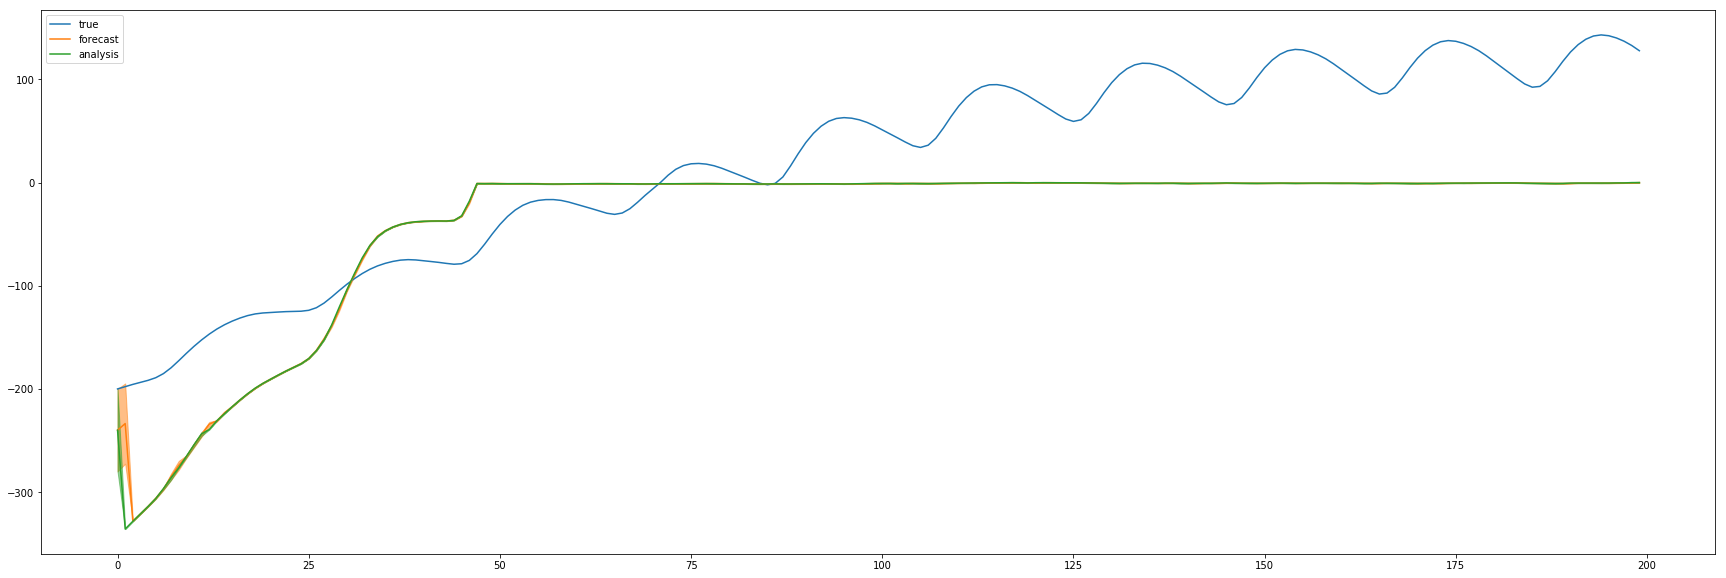

In [14]:
_i = 0
T = 200
plt.figure(figsize=(30,10))

lt, = plt.plot(state_data[:T,_i])
lf, = plt.plot(xfm[:T,_i])
la, = plt.plot(xam[:T,_i])

plt.fill_between(range(T),xfm[:T,_i] - np.sqrt(xfcov[:T,_i,_i]),xfm[:T,_i] + np.sqrt(xfcov[:T,_i,_i]),alpha=0.5,color=lf.get_color())
plt.fill_between(range(T),xam[:T,_i] - np.sqrt(xacov[:T,_i,_i]),xam[:T,_i] + np.sqrt(xacov[:T,_i,_i]),alpha=0.5,color=la.get_color())

plt.legend(['true','forecast','analysis'])

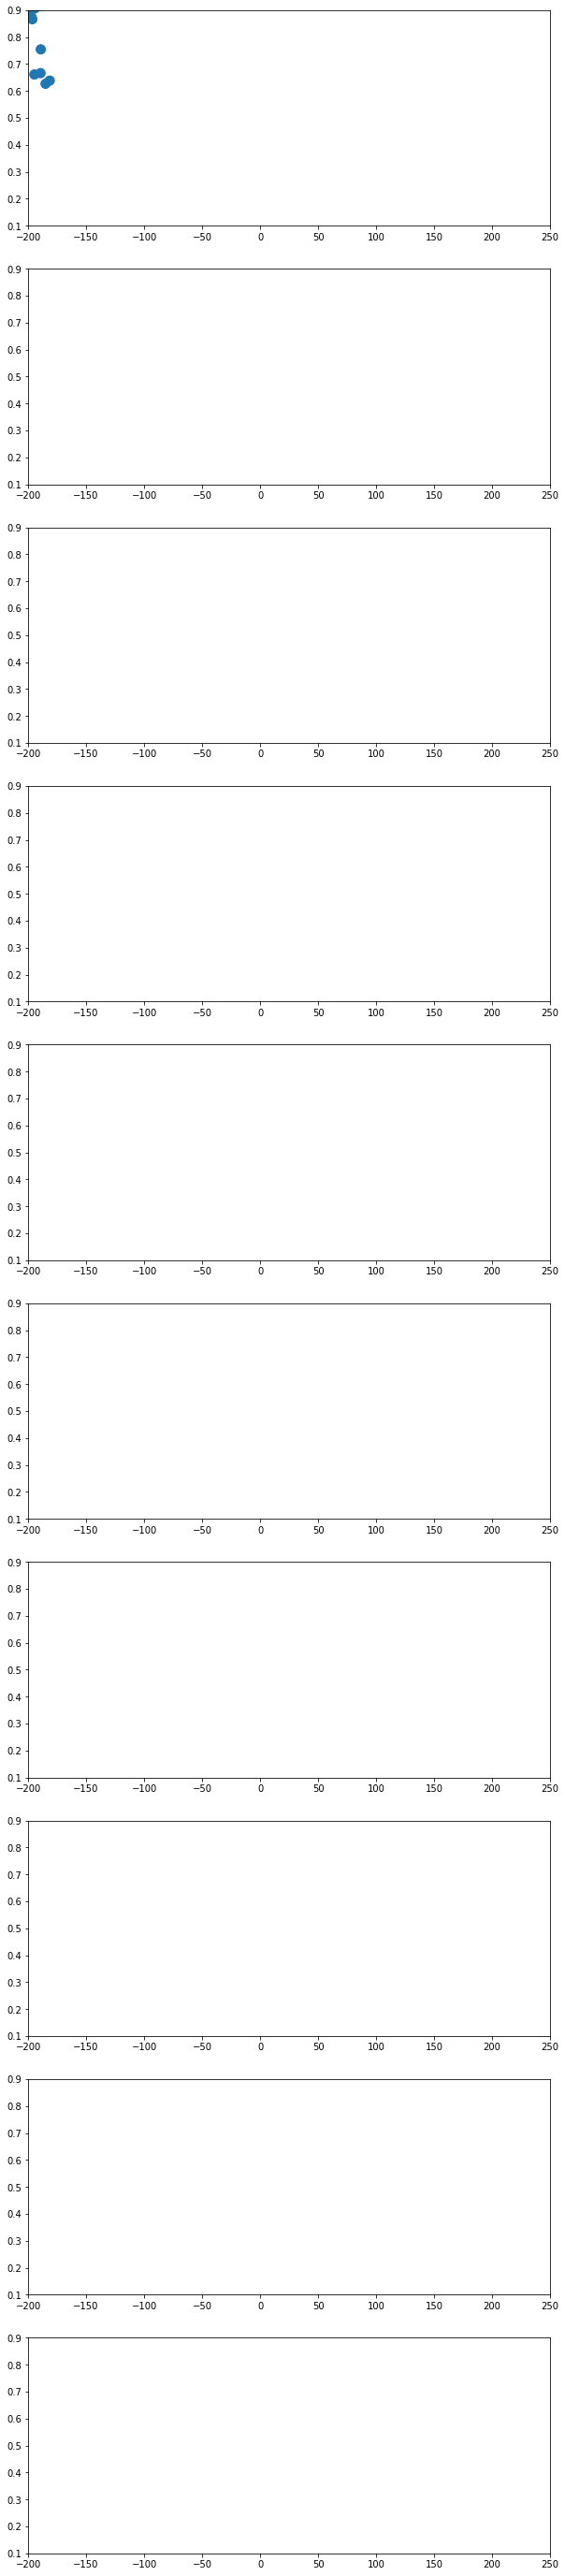

In [19]:
f,axes=plt.subplots(10,1,figsize=(10,50))
for _t in range(10):
    axes[_t].scatter(phist[_t,:,0],phist[_t,:,1],1e4*whist[_t,:])
    axes[_t].set_xlim([-200,250])
    axes[_t].set_ylim([0.1,0.9])

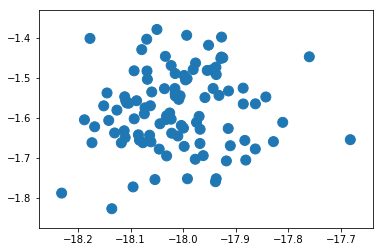

In [35]:
_t = 46
plt.scatter(phist[_t,:,0],phist[_t,:,1],1e4*whist[_t,:])

In [38]:
phist[46,...]

array([[-18.05364136,  -1.75409009],
       [-18.04405046,  -1.61474021],
       [-17.88595282,  -1.52568946],
       [-18.02278525,  -1.60319753],
       [-18.01563438,  -1.52682087],
       [-18.09324898,  -1.48246035],
       [-18.02556763,  -1.58776746],
       [-17.99811952,  -1.49408682],
       [-17.95857509,  -1.54927389],
       [-17.95422366,  -1.48151891],
       [-17.84279159,  -1.5478023 ],
       [-18.07871171,  -1.42950596],
       [-17.999399  ,  -1.62549472],
       [-17.93708299,  -1.49180472],
       [-18.01523574,  -1.48919589],
       [-18.01514806,  -1.5386426 ],
       [-18.00581889,  -1.54478081],
       [-17.9763985 ,  -1.46291808],
       [-18.08512806,  -1.64233914],
       [-17.91435152,  -1.62653305],
       [-17.92703406,  -1.39827094],
       [-17.92725171,  -1.44804898],
       [-18.0498869 ,  -1.37917174],
       [-17.91784026,  -1.70755902],
       [-17.88571466,  -1.56528006],
       [-17.92459908,  -1.45000645],
       [-17.9517375 ,  -1.41848913],
 

In [43]:
truestate[46,...]

array([-75.40440261,   0.44818022])

In [55]:
xens = phist[46,...]
yens = Hm(xens)
w_stats = DescrStatsW(yens,weights=xweights)

innov = yens - yobs[46,:]

Wexp = np.zeros(nens)
for _ii in range(nens):
    Wexp[_ii] = -0.5*innov[_ii,:] @ Robsmat_inv @ innov[_ii,:].T

#Wexp =  -0.5*innov @ Robsmat_inv @ innov.T
#Wexp = np.diag(Wexp)
Wmax = np.max(Wexp)
Wexp = Wexp - Wmax
print(Wmax)
W = xweights * np.exp(Wexp)
W = W/np.sum(W)

-47699.69315504392


In [56]:
W

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [52]:
##test for resampling
if 1/np.sum(W ** 2)/nens < resamp_thresh:
    resampcount += 1
    print('Resampling the %dth time'%resampcount)
    sampIndex = resampleMultinomial(W)
    xens = xens[sampIndex,:] + wiggle*np.random.normal(0,1,size=(nens,ndim))
    W2 = np.ones(nens)/nens

Resampling the 194th time


In [53]:
W2

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [145]:
whist[0,:]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

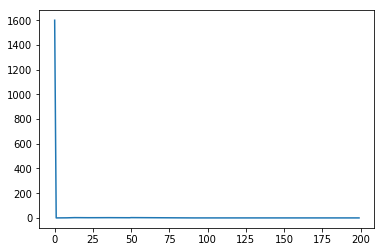

In [99]:
plt.plot(xacov[:,0,0])

In [365]:
yfm = enkf.Hm(xfm)
yam = enkf.Hm(xam)

NameError: name 'yam' is not defined

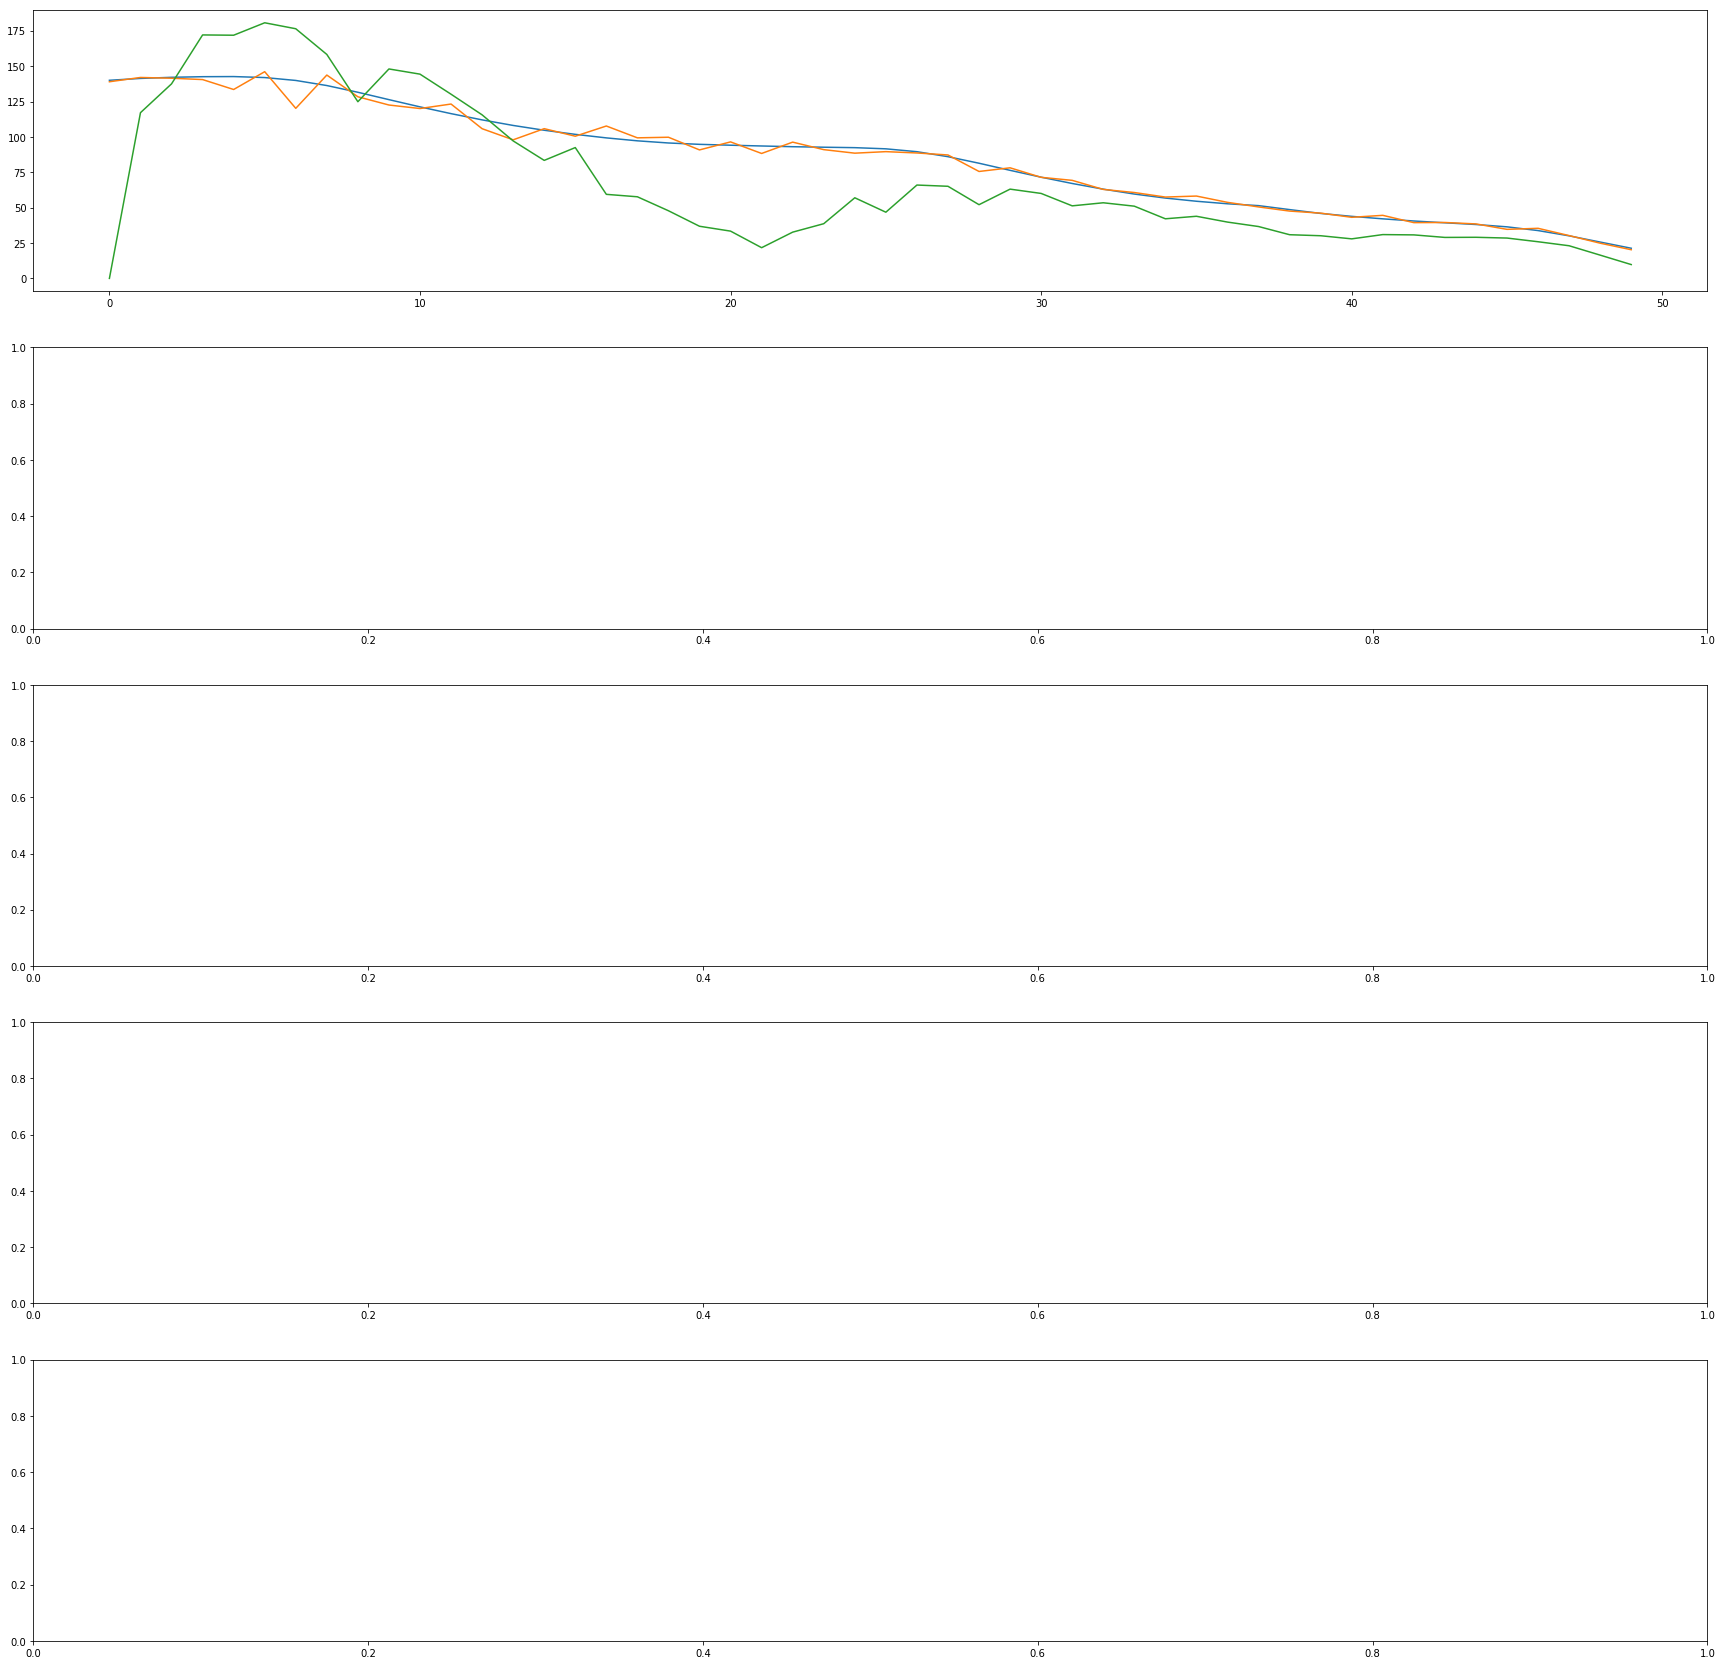

In [75]:
f,axes = plt.subplots(5,1,figsize=(30,30))
for _i in range(5):

    lt, = axes[_i].plot(obs_data_true[:T,_i])
    lt, = axes[_i].plot(obs_data[:T,_i])
    lf, = axes[_i].plot(yfm[:T,_i])
    la, = axes[_i].plot(yam[:T,_i])

In [158]:
np.sqrt(2)

1.4142135623730951

In [103]:
state_data.shape

(1000, 2)

In [169]:
sigmainit=0.9
xinit=np.array([-200,0.7])

sigma = xinit * np.clip(sigmainit * np.random.randn(*xinit.shape),-0.1,0.1)

In [170]:
np.identity(2) * (sigma ** 2)

array([[4.0e+02, 0.0e+00],
       [0.0e+00, 4.9e-03]])

In [171]:
xens = np.random.multivariate_normal(xinit, np.identity(2) * (sigma ** 2), 100)

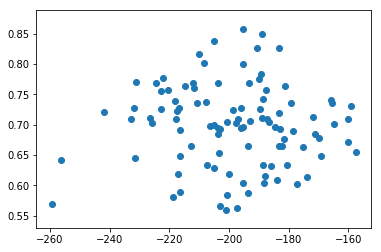

In [172]:
plt.scatter(xens[:,0],xens[:,1])